In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define the Auto-Encoder Architecture
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Data Preparation
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Initialize Model, Loss, and Optimizer
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Auto-Encoder
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for data, _ in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}')


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.69MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 149kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:03<00:00, 419kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.07MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Loss: 0.0458
Epoch 2, Loss: 0.0234
Epoch 3, Loss: 0.0181
Epoch 4, Loss: 0.0155
Epoch 5, Loss: 0.0140
Epoch 6, Loss: 0.0128
Epoch 7, Loss: 0.0119
Epoch 8, Loss: 0.0112
Epoch 9, Loss: 0.0106
Epoch 10, Loss: 0.0101


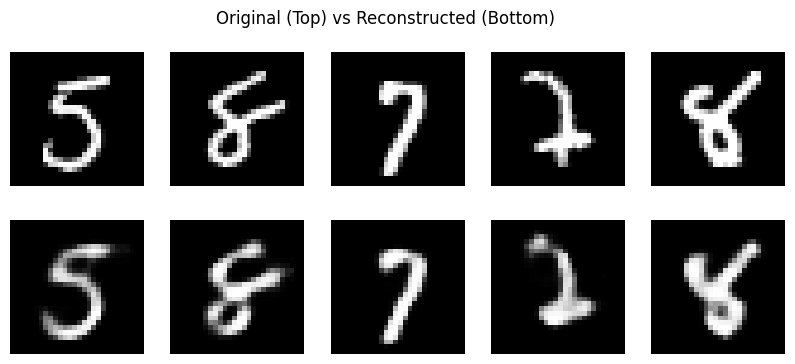

In [2]:
# Select a few samples from the test set for visualization
# Visualize Reconstruction Results

test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=5, shuffle=True)

# Get a batch and visualize
data, _ = next(iter(test_loader))
reconstructed = model(data)

# Plot original vs reconstructed images
plt.figure(figsize=(10, 4))
for i in range(5):
    # Original
    plt.subplot(2, 5, i + 1)
    plt.imshow(data[i].view(28, 28).detach().numpy(), cmap='gray')
    plt.axis('off')
    # Reconstructed
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed[i].view(28, 28).detach().numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
plt.show()


Epoch 1, Loss: 0.0143
Epoch 2, Loss: 0.0132
Epoch 3, Loss: 0.0128
Epoch 4, Loss: 0.0126
Epoch 5, Loss: 0.0123
Epoch 6, Loss: 0.0121
Epoch 7, Loss: 0.0119
Epoch 8, Loss: 0.0117
Epoch 9, Loss: 0.0116
Epoch 10, Loss: 0.0114


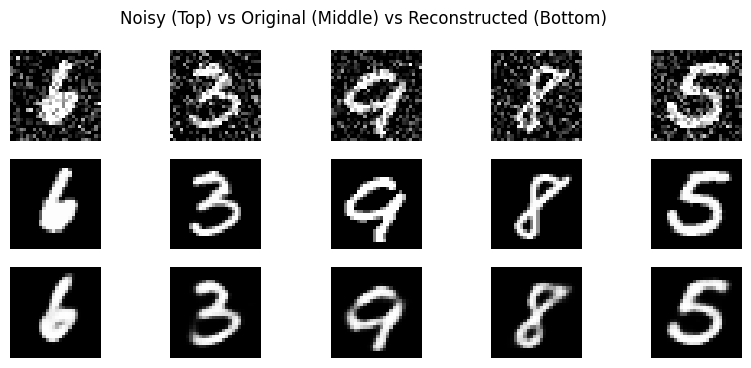

In [ ]:
# Add noise to the images
#Denoising Auto-Encoder (DAE)
def add_noise(img, noise_factor=0.3):
    noisy_img = img + noise_factor * torch.randn(*img.shape)
    return torch.clip(noisy_img, 0., 1.)

# Modify the training loop for Denoising Auto-Encoder
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for data, _ in train_loader:
        noisy_data = add_noise(data)  # Add noise
        optimizer.zero_grad()
        output = model(noisy_data)  # Train on noisy data
        loss = criterion(output, data)  # Compare with original data
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}')

# Visualize the reconstruction on noisy images
noisy_data = add_noise(data)
reconstructed = model(noisy_data)

plt.figure(figsize=(10, 4))
for i in range(5):
    # Noisy
    plt.subplot(3, 5, i + 1)
    plt.imshow(noisy_data[i].view(28, 28).detach().numpy(), cmap='gray')
    plt.axis('off')
    # Original
    plt.subplot(3, 5, i + 6)
    plt.imshow(data[i].view(28, 28).detach().numpy(), cmap='gray')
    plt.axis('off')
    # Reconstructed
    plt.subplot(3, 5, i + 11)
    plt.imshow(reconstructed[i].view(28, 28).detach().numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle("Noisy (Top) vs Original (Middle) vs Reconstructed (Bottom)")
plt.show()


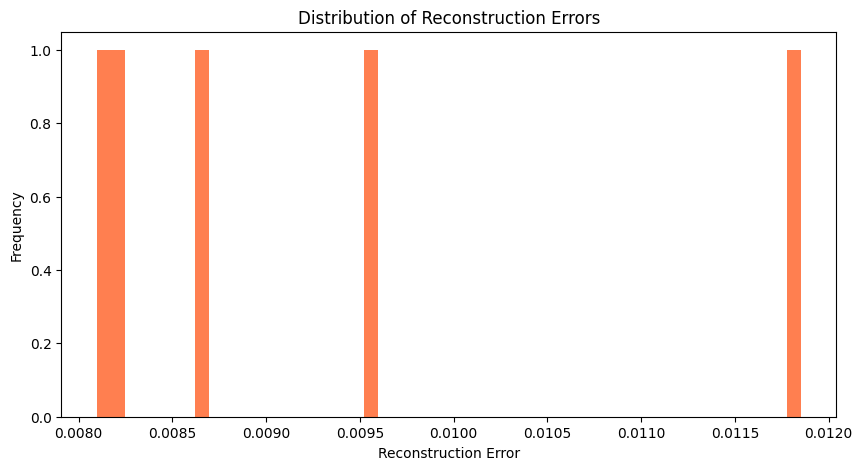

Detected 1 anomalies out of 5 samples.


In [4]:
#Anomaly Detection with Auto-Encoders


import numpy as np

# Calculate reconstruction error
def reconstruction_error(data, reconstructed):
    return np.mean((data - reconstructed) ** 2, axis=1)

# Visualize reconstruction error distribution
data, _ = next(iter(test_loader))
reconstructed = model(data)
errors = reconstruction_error(data.detach().numpy(), reconstructed.detach().numpy())

# Histogram of reconstruction errors
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, color='coral')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.show()

# Set a threshold for anomaly detection (e.g., top 5% errors)
threshold = np.percentile(errors, 95)
anomalies = errors > threshold
print(f"Detected {anomalies.sum()} anomalies out of {len(errors)} samples.")
